In [1]:
import numpy as np
import torch
import tensorflow as tf

2023-12-04 02:50:48.658809: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 02:50:48.658888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 02:50:48.660239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 02:50:48.666531: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 02:50:49.402828: W tensorflow/compiler/tf2

In [2]:
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

# Multiplication

In [3]:
def matmul_time(a, b):
    start = time()
    a @ b
    return time() - start

np_times, torch_cpu_times, torch_gpu_times, tf_cpu_times, tf_gpu_times = [], [], [], [], []
for size in tqdm(range(1000, 20000, 2000)):
    cur_np_times, cur_torch_cpu_times, cur_torch_gpu_times, cur_tf_cpu_times, cur_tf_gpu_times = [], [], [], [], []
    for _ in range(10):
        a = np.random.rand(size, size)
        b = np.random.rand(size, size)
        
        # Numpy
        t = matmul_time(a, b)
        cur_np_times.append(t)
        
        # Torch CPU
        torch_a, torch_b = torch.from_numpy(a), torch.from_numpy(b)
        t = matmul_time(torch_a, torch_b)
        cur_torch_cpu_times.append(t)
        
        # Torch GPU
        if size <= 8000:
            t = matmul_time(torch_a.to("cuda"), torch_b.to("cuda"))
            cur_torch_gpu_times.append(t)
            torch.cuda.empty_cache()
        
        # TF CPU
        with tf.device("/cpu:0"):
            tf_a, tf_b = tf.convert_to_tensor(a), tf.convert_to_tensor(b)
            t = matmul_time(tf_a, tf_b)
            cur_tf_cpu_times.append(t)
            
        # TF GPU
        if size <= 8000:
            tf_a, tf_b = tf.convert_to_tensor(a), tf.convert_to_tensor(b)
            t = matmul_time(tf_a, tf_b)
            cur_tf_gpu_times.append(t)
        
        # Clean Memory?
        gc.collect()
        
    np_times.append(np.median(cur_np_times))
    torch_cpu_times.append(np.median(cur_torch_cpu_times))
    torch_gpu_times.append(np.median(cur_torch_gpu_times))
    tf_cpu_times.append(np.median(cur_tf_cpu_times))
    tf_gpu_times.append(np.median(cur_tf_gpu_times))

  0%|          | 0/10 [00:00<?, ?it/s]2023-12-04 01:27:31.240626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22429 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:05:00.0, compute capability: 8.6
2023-12-04 01:27:31.241680: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22459 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:06:00.0, compute capability: 8.6
2023-12-04 01:27:31.242419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22459 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:45:00.0, compute capability: 8.6
2023-12-04 01:27:31.243162: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22459 MB memory:  -> de

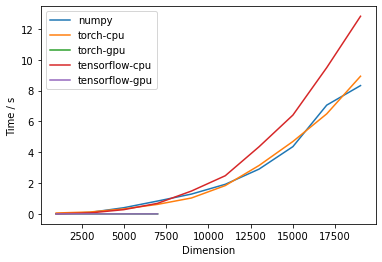

In [8]:
x_axis = list(range(1000, 20000, 2000))
x_axis_gpu = x_axis[:len(torch_gpu_times)]
plt.plot(x_axis, np_times, label="numpy")
plt.plot(x_axis, torch_cpu_times, label="torch-cpu")
plt.plot(x_axis_gpu, torch_gpu_times, label="torch-gpu")
plt.plot(x_axis, tf_cpu_times, label="tensorflow-cpu")
plt.plot(x_axis_gpu, tf_gpu_times, label="tensorflow-gpu")
plt.ylabel("Time / s")
plt.xlabel("Dimension")
plt.legend()
plt.savefig("matmul.pdf")
plt.show()

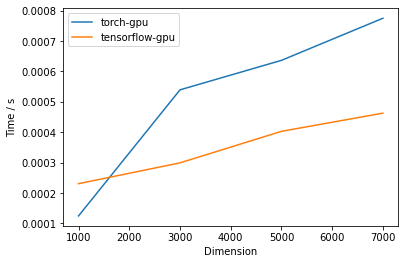

In [12]:
plt.plot(x_axis_gpu, torch_gpu_times, label="torch-gpu")
plt.plot(x_axis_gpu, tf_gpu_times, label="tensorflow-gpu")
plt.ylabel("Time / s")
plt.xlabel("Dimension")
plt.legend()
plt.savefig("matmul_gpu.pdf")
plt.show()

In [15]:
print(np_times)
print(torch_cpu_times)
print(torch_gpu_times)
print(tf_cpu_times)
print(tf_gpu_times)

[0.013087868690490723, 0.09664571285247803, 0.4025695323944092, 0.835565447807312, 1.2865707874298096, 1.9201611280441284, 2.907043695449829, 4.363798141479492, 7.054605484008789, 8.322551369667053]
[0.060819029808044434, 0.12402701377868652, 0.3248147964477539, 0.6194478273391724, 1.0325666666030884, 1.8371477127075195, 3.1425046920776367, 4.696524500846863, 6.489637970924377, 8.930015563964844]
[0.00012481212615966797, 0.0005395412445068359, 0.0006365776062011719, 0.0007750988006591797, nan, nan, nan, nan, nan, nan]
[0.007883310317993164, 0.065498948097229, 0.2767084836959839, 0.6876538991928101, 1.4837604761123657, 2.476114273071289, 4.357150554656982, 6.408845543861389, 9.486512303352356, 12.819342970848083]
[0.00023090839385986328, 0.0002993345260620117, 0.0004030466079711914, 0.0004628896713256836, nan, nan, nan, nan, nan, nan]


# Inverse

In [3]:
def matmul_time(a, inv_func):
    start = time()
    inv_func(a)
    return time() - start

np_times, torch_cpu_times, torch_gpu_times, tf_cpu_times, tf_gpu_times = [], [], [], [], []
for size in tqdm(range(1000, 3600, 200)):
    cur_np_times, cur_torch_cpu_times, cur_torch_gpu_times, cur_tf_cpu_times, cur_tf_gpu_times = [], [], [], [], []
    for _ in range(10):
        a = np.random.rand(size, size)
        
        # Numpy
        t = matmul_time(a, np.linalg.inv)
        cur_np_times.append(t)
        
        # Torch CPU
        torch_a = torch.from_numpy(a)
        t = matmul_time(torch_a, torch.linalg.inv)
        cur_torch_cpu_times.append(t)
        
        # Torch GPU
        if size <= 8000:
            t = matmul_time(torch_a.to("cuda"), torch.linalg.inv)
            cur_torch_gpu_times.append(t)
            torch.cuda.empty_cache()
        
        # TF CPU
        with tf.device("/cpu:0"):
            tf_a = tf.convert_to_tensor(a)
            t = matmul_time(tf_a, tf.linalg.inv)
            cur_tf_cpu_times.append(t)
            
        # TF GPU
        if size <= 8000:
            tf_a = tf.convert_to_tensor(a)
            t = matmul_time(tf_a, tf.linalg.inv)
            cur_tf_gpu_times.append(t)
        
        # Clean Memory?
        gc.collect()
        
    np_times.append(np.median(cur_np_times))
    torch_cpu_times.append(np.median(cur_torch_cpu_times))
    torch_gpu_times.append(np.median(cur_torch_gpu_times))
    tf_cpu_times.append(np.median(cur_tf_cpu_times))
    tf_gpu_times.append(np.median(cur_tf_gpu_times))

  0%|          | 0/11 [00:00<?, ?it/s]2023-12-04 02:51:31.540191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22353 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:05:00.0, compute capability: 8.6
2023-12-04 02:51:31.540887: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22417 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:06:00.0, compute capability: 8.6
2023-12-04 02:51:31.541840: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22417 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:45:00.0, compute capability: 8.6
2023-12-04 02:51:31.542623: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22417 MB memory:  -> de

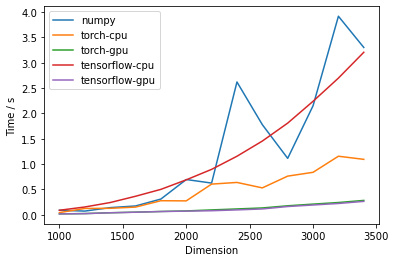

In [10]:
x_axis = list(range(1000, 3600, 200))
x_axis_gpu = x_axis[:len(torch_gpu_times)]
plt.plot(x_axis, np_times, label="numpy")
plt.plot(x_axis, torch_cpu_times, label="torch-cpu")
plt.plot(x_axis_gpu, torch_gpu_times, label="torch-gpu")
plt.plot(x_axis, tf_cpu_times, label="tensorflow-cpu")
plt.plot(x_axis_gpu, tf_gpu_times, label="tensorflow-gpu")
plt.ylabel("Time / s")
plt.xlabel("Dimension")
plt.legend()
plt.savefig("inv.pdf")
plt.show()

In [11]:
print(np_times)
print(torch_cpu_times)
print(torch_gpu_times)
print(tf_cpu_times)
print(tf_gpu_times)

[0.0882570743560791, 0.07132983207702637, 0.1396721601486206, 0.1724332571029663, 0.3088337182998657, 0.6944118738174438, 0.62449049949646, 2.6201913356781006, 1.777741551399231, 1.112488865852356, 2.15114688873291, 3.9181164503097534, 3.301564574241638]
[0.04126143455505371, 0.12348043918609619, 0.12634456157684326, 0.15021789073944092, 0.276192307472229, 0.27306294441223145, 0.6042512655258179, 0.6369669437408447, 0.529413104057312, 0.7617592811584473, 0.8370314836502075, 1.1546200513839722, 1.0928301811218262]
[0.015929102897644043, 0.022294163703918457, 0.03834259510040283, 0.050446271896362305, 0.06364703178405762, 0.07482266426086426, 0.09461617469787598, 0.11383116245269775, 0.1334155797958374, 0.1760317087173462, 0.2091672420501709, 0.24061870574951172, 0.2821089029312134]
[0.08770203590393066, 0.15224802494049072, 0.2399836778640747, 0.3639521598815918, 0.500206708908081, 0.6883397102355957, 0.8952217102050781, 1.1540396213531494, 1.4539865255355835, 1.808295726776123, 2.23906

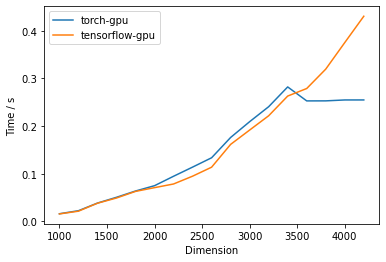

In [14]:
x_axis_gpu = list(range(1000, 4400, 200))
plt.plot(x_axis_gpu, torch_gpu_times, label="torch-gpu")
plt.plot(x_axis_gpu, tf_gpu_times, label="tensorflow-gpu")
plt.ylabel("Time / s")
plt.xlabel("Dimension")
plt.legend()
# plt.savefig("inv_gpu.pdf")
plt.show()

In [13]:
for size in tqdm(range(3600, 4400, 200)):
    cur_np_times, cur_torch_cpu_times, cur_torch_gpu_times, cur_tf_cpu_times, cur_tf_gpu_times = [], [], [], [], []
    for _ in range(10):
        a = np.random.rand(size, size)
        
        # Torch GPU
        t = matmul_time(torch_a.to("cuda"), torch.linalg.inv)
        cur_torch_gpu_times.append(t)
        torch.cuda.empty_cache()
            
        # TF GPU
        tf_a = tf.convert_to_tensor(a)
        t = matmul_time(tf_a, tf.linalg.inv)
        cur_tf_gpu_times.append(t)
        
        # Clean Memory?
        gc.collect()
        
    torch_gpu_times.append(np.median(cur_torch_gpu_times))
    tf_gpu_times.append(np.median(cur_tf_gpu_times))

100%|██████████| 4/4 [00:37<00:00,  9.50s/it]


# QR Decomposition

In [15]:
def matmul_time(a, qr_func):
    start = time()
    qr_func(a)
    return time() - start

np_times, torch_cpu_times, torch_gpu_times, tf_cpu_times, tf_gpu_times = [], [], [], [], []
for size in tqdm(range(1000, 2200, 200)):
    cur_np_times, cur_torch_cpu_times, cur_torch_gpu_times, cur_tf_cpu_times, cur_tf_gpu_times = [], [], [], [], []
    for _ in range(10):
        a = np.random.rand(size, size)
        
        # Numpy
        t = matmul_time(a, np.linalg.qr)
        cur_np_times.append(t)
        
        # Torch CPU
        torch_a = torch.from_numpy(a)
        t = matmul_time(torch_a, torch.linalg.qr)
        cur_torch_cpu_times.append(t)
        
        # Torch GPU
        if size <= 8000:
            t = matmul_time(torch_a.to("cuda"), torch.linalg.qr)
            cur_torch_gpu_times.append(t)
            torch.cuda.empty_cache()
        
        # TF CPU
        with tf.device("/cpu:0"):
            tf_a = tf.convert_to_tensor(a)
            t = matmul_time(tf_a, tf.linalg.qr)
            cur_tf_cpu_times.append(t)
            
        # TF GPU
        if size <= 8000:
            tf_a = tf.convert_to_tensor(a)
            t = matmul_time(tf_a, tf.linalg.qr)
            cur_tf_gpu_times.append(t)
        
        # Clean Memory?
        gc.collect()
        
    np_times.append(np.median(cur_np_times))
    torch_cpu_times.append(np.median(cur_torch_cpu_times))
    torch_gpu_times.append(np.median(cur_torch_gpu_times))
    tf_cpu_times.append(np.median(cur_tf_cpu_times))
    tf_gpu_times.append(np.median(cur_tf_gpu_times))

100%|██████████| 6/6 [02:34<00:00, 25.76s/it]


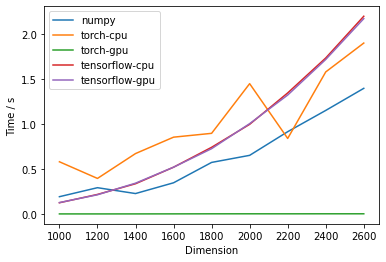

In [19]:
x_axis = list(range(1000, 2800, 200))
x_axis_gpu = x_axis[:len(torch_gpu_times)]
plt.plot(x_axis, np_times, label="numpy")
plt.plot(x_axis, torch_cpu_times, label="torch-cpu")
plt.plot(x_axis_gpu, torch_gpu_times, label="torch-gpu")
plt.plot(x_axis, tf_cpu_times, label="tensorflow-cpu")
plt.plot(x_axis_gpu, tf_gpu_times, label="tensorflow-gpu")
plt.ylabel("Time / s")
plt.xlabel("Dimension")
plt.legend()
plt.savefig("qr.pdf")
plt.show()

In [17]:
for size in tqdm(range(2200, 2800, 200)):
    cur_np_times, cur_torch_cpu_times, cur_torch_gpu_times, cur_tf_cpu_times, cur_tf_gpu_times = [], [], [], [], []
    for _ in range(10):
        a = np.random.rand(size, size)
        
        # Numpy
        t = matmul_time(a, np.linalg.qr)
        cur_np_times.append(t)
        
        # Torch CPU
        torch_a = torch.from_numpy(a)
        t = matmul_time(torch_a, torch.linalg.qr)
        cur_torch_cpu_times.append(t)
        
        # Torch GPU
        if size <= 8000:
            t = matmul_time(torch_a.to("cuda"), torch.linalg.qr)
            cur_torch_gpu_times.append(t)
            torch.cuda.empty_cache()
        
        # TF CPU
        with tf.device("/cpu:0"):
            tf_a = tf.convert_to_tensor(a)
            t = matmul_time(tf_a, tf.linalg.qr)
            cur_tf_cpu_times.append(t)
            
        # TF GPU
        if size <= 8000:
            tf_a = tf.convert_to_tensor(a)
            t = matmul_time(tf_a, tf.linalg.qr)
            cur_tf_gpu_times.append(t)
        
        # Clean Memory?
        gc.collect()
        
    np_times.append(np.median(cur_np_times))
    torch_cpu_times.append(np.median(cur_torch_cpu_times))
    torch_gpu_times.append(np.median(cur_torch_gpu_times))
    tf_cpu_times.append(np.median(cur_tf_cpu_times))
    tf_gpu_times.append(np.median(cur_tf_gpu_times))

100%|██████████| 3/3 [03:15<00:00, 65.04s/it]


In [20]:
print(np_times)
print(torch_cpu_times)
print(torch_gpu_times)
print(tf_cpu_times)
print(tf_gpu_times)

[0.1930687427520752, 0.29314351081848145, 0.2279752492904663, 0.3476419448852539, 0.5740342140197754, 0.6526920795440674, 0.915495753288269, 1.1520136594772339, 1.3975833654403687]
[0.5812894105911255, 0.39611923694610596, 0.6724624633789062, 0.8547548055648804, 0.8973274230957031, 1.4494110345840454, 0.8405594825744629, 1.579888939857483, 1.9008455276489258]
[0.001746058464050293, 0.0016571283340454102, 0.0018270015716552734, 0.0021975040435791016, 0.0028156042098999023, 0.002933502197265625, 0.002755403518676758, 0.0030508041381835938, 0.0030089616775512695]
[0.12570202350616455, 0.21828889846801758, 0.336950421333313, 0.520844578742981, 0.7420986890792847, 0.9972869157791138, 1.34644615650177, 1.7348791360855103, 2.1988765001296997]
[0.12765097618103027, 0.21456563472747803, 0.34332549571990967, 0.5211648941040039, 0.7268861532211304, 1.0051809549331665, 1.3230167627334595, 1.7184176445007324, 2.1725796461105347]


In [23]:
for _ in range(50):
    with tf.device("/cpu:0"):
        matmul_time(np.random.rand(3000, 3000), tf.linalg.qr)